In [1]:
pwd

'/Users/edwardterrell/Desktop/covid_machinations'

In [2]:
# this block is used for copying/moving files
import os
import shutil
#shutil.copyfile('src', 'dst')
#shutil.move

# we want to ensure we are in the correct conda environment
import sys
sys.executable

'/Users/edwardterrell/opt/anaconda3/envs/scrape/bin/python'

In [3]:
# This is a python module with dictionaries of states and countries; it also contains three functions repair_dict, reverse_dict, and custom_list
import state_country_dicts as scd

In [4]:
# provides ability to reload modules (wihtout leaving jupyter) if changes are made
# import importlib
# importlib.reload(scd)

In [5]:
import numpy as np
import pandas as pd

In [6]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import matplotlib.pyplot as plt

import requests
from bs4 import BeautifulSoup as bs
# import regular expressions
import re 

#import dateutil.parser
import time

from IPython.core.display import HTML
css = open('style-table.css').read() + open('style-notebook.css').read()
HTML('<style>{}</style>'.format(css))

### Cornavirus section

In [7]:
# get current date for use in creating filenames with embedded 'day'. 
# convert datetime object to string
import datetime as dt
today  = dt.date.today()
day = today.strftime('%Y-%m-%d')
day

'2021-04-08'

In [8]:
cd ..

/Users/edwardterrell/Desktop


In [11]:
# House keeping Desktop's covid_data_update folder
# prepare move of all files from covid_data_update to covid_data 
file_names = []
source_dir = 'covid_data_update'
target_dir = 'covid_data'
print("covid_data_update directory contents:") 

file_names = os.listdir(source_dir)
print (file_names)
if file_names == []:
    print ('Directory is empty so no files available to move')

covid_data_update directory contents:
['us_2021-04-05.png', 'Covid programs summary.txt', 'world_rolling_avg_2021-04-05.png', 'us_IL_MN_MO_last_60_days_2021-04-05.png', 'us_IL_MN_MO_last_90_days_2021-04-05.png', 'outbreaks-DATE-2021-04-05.csv', 'boulder-2021-04-05.csv', 'world_DE_ES_FR_UK_IT_last_90_days_2021-04-05.png', 'world_DE_ES_FR_UK_IT_last_60_days_2021-04-05.png', 'world_2021-04-05.png', 'outbreaks-per-month-2021-04-05.png', 'outbreaks-TOTAL-2021-04-05.csv', 'outbreaks-COUNTY-2021-04-05.csv', 'outbreaks-TYPE-2021-04-05.csv', 'us_rolling_avg_2021-04-05.png']


### Moves all files from covid_data_update to covid_data 

In [12]:
%%capture
# Move contents of source ('covid_data_update')to target ('covid_data')
for file_name in file_names:
    shutil.move(os.path.join(source_dir, file_name), target_dir)

In [13]:
def clean_up (number_str):
    '''This is a clean up routine so that only numeric characters remain'''
    number_str = number_str.replace(',', '').rstrip(']').lstrip("'")
    return int(number_str)

### Custom state dictionaries

In [15]:
# creates a custom state dict
s_string = input('Enter state codes seperated by a space:') or 'ca tx fl az co ny il'
print()

slist = scd.custom_list (s_string)
state_dict = {key: value for key, value in scd.all_states.items() if value in slist}
state_dict

Enter state codes seperated by a space: co


{'colorado': 'CO'}

### State Scraping section

In [16]:
# The start dates for U.S.states and for countries are different so must be accounted for
st_start = pd.Timestamp('2020/3/13')
c_start = pd.Timestamp('2020/2/16')

# set end time to yesterday
end = pd.Timestamp.today() - pd.Timedelta(days=1)

# set the index to the appropriate date range for states and countries
st_index = pd.date_range(st_start, end)
c_index = pd.date_range(c_start, end)
len(st_index)
len(c_index)

# list comprehension to extract just the state initials from the dict
st_list = list(state_dict.values())

# create an empty pandas df with column headers from state_dict
state = pd.DataFrame(columns = st_list,index=st_index)
state.tail()

391

417

,CO
2021-04-03,NaN
2021-04-04,NaN
2021-04-05,NaN
2021-04-06,NaN
2021-04-07,NaN


In [17]:
state_url='https://www.worldometers.info/coronavirus/usa/'
# Here the keys are the state names and the values are the 2-letter abbreviation
for key, value in state_dict.items():
    url = state_url+key

    # scrape web page for state info and assign to soup
    response = requests.get(url)
    #response.status_code
    page = response.text
    soup = bs(page)
    
    # Find block of text/data near 'graph-cases-daily' 
    re_graph = re.compile('graph-cases')
    try:
        data = soup.find(text=re_graph).parent
    except:
        print(f'Unable to find {url}')
        print()
        break
    

    # Regex to pull out data chunk out of the larger soup like data
    myregex = re.compile (r'data:.*\]')
    mo = myregex.search(str(data))

    #mo.group() is a string so easy to get rid of the first entry
    #state_previous_cases is a list of daily new coronavirus cases
    state_previous_cases = mo.group().split(',')[1:]
        
    len(state_previous_cases)

    # merge states into the existing df and apply the function clean_up to convert strings to ints
    # state[value] where value is the 2-letter abreviation
    state[value] = state_previous_cases
    state[value] = state[value].apply(clean_up)
    
    time.sleep(2)
state.tail()    

391

,CO
2021-04-03,1571
2021-04-04,1220
2021-04-05,867
2021-04-06,1266
2021-04-07,1913


In [18]:
def list2string(l): 
    ''' This creates a a short string of state/country names 
    used during file save
    '''
    str1 = "_" 
    # return string  
    return (str1.join(l))

States available: ['CO']



Choose state for rolling averge: 


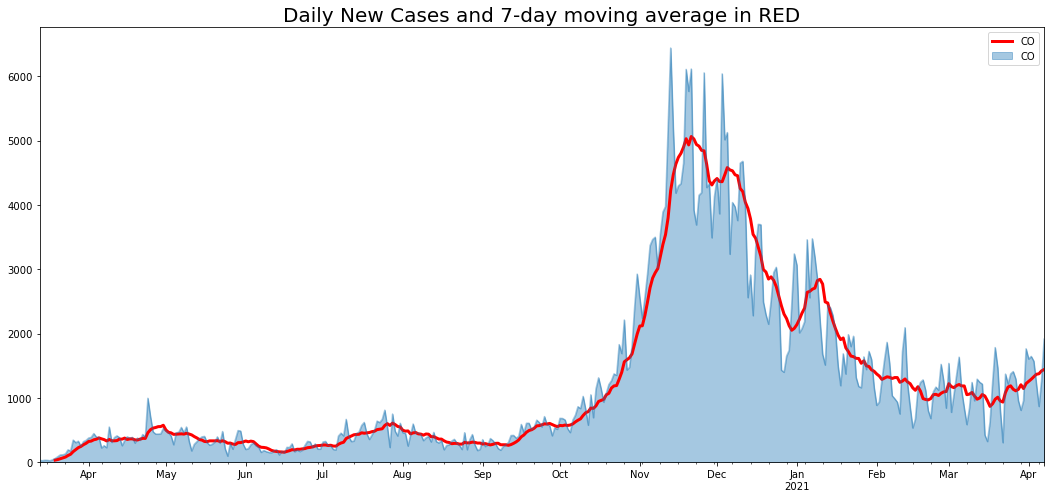

In [19]:
# Allows user to select state for rolling average 
s_available = list(state.columns)
print(f'States available: {s_available}')
print()

snames = (list2string(s_available))

select_state = input('Choose state for rolling averge:')or s_available[0]
select_state = select_state.upper()

if select_state not in s_available:
    select_state = s_available[0]

# Plot Daily New Cases and 7-day moving averge
fig,ax = plt.subplots(1,1,figsize=(18,8))
roll_data = state.loc[:,[select_state]].rolling(window=7).mean()

roll_data.plot(ax=ax, linewidth=3, color='r')
state.plot(kind='area',alpha=.4,ax=ax,stacked=False);
plt.title('Daily New Cases and 7-day moving average in RED', fontsize=20) 

#ax.set_title('Daily New Cases and 7-day moving average in RED', fontsize=20) 
plt.savefig(f'./covid_data_update/us_{day}.png');

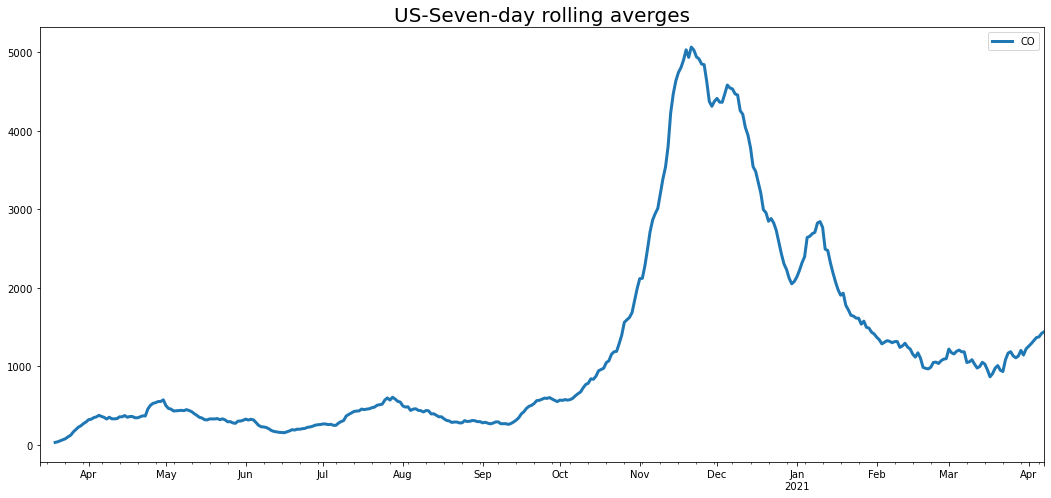

In [20]:
# Plot 7-day moving averge
plt.close('all')
fig,ax = plt.subplots(1,1,figsize=(18,8))
roll_data_all = state.rolling(window=7).mean()
roll_data_all.plot(ax=ax, linewidth=3);
plt.title('US-Seven-day rolling averges',fontsize=20)
plt.savefig(f'./covid_data_update/us_rolling_avg_{day}.png');

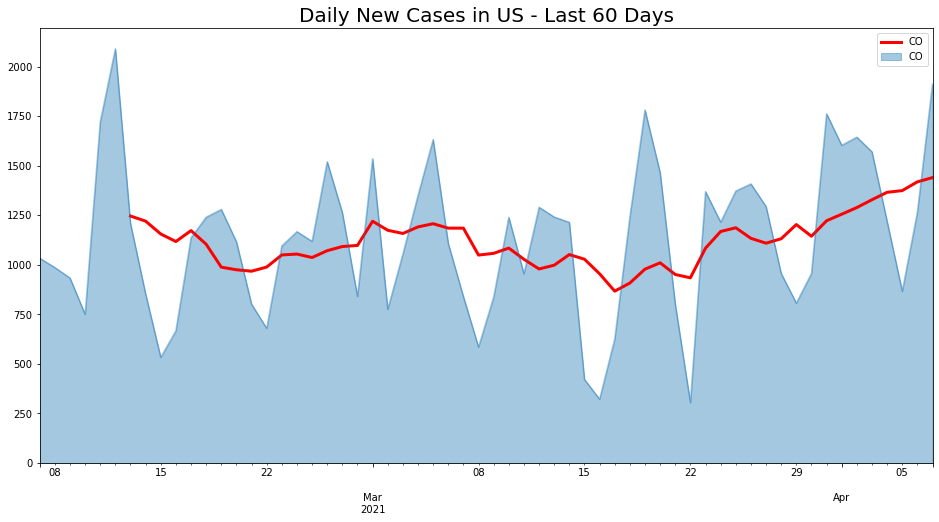

In [21]:
# Plot Last 60 Days
plt.close('all')
# Select last 60 days only
state_last60 = state.tail(60)

roll_data = state_last60.loc[:,[select_state]].rolling(window=7).mean()
fig,ax = plt.subplots(1,1,figsize=(16,8))
roll_data.plot(ax=ax, linewidth=3, color='r')
state_last60.plot(kind='area',alpha=.4,ax=ax,stacked=False);

plt.title('Daily New Cases in US - Last 60 Days',fontsize=20)
plt.savefig(f'./covid_data_update/us_{snames}_last_60_days_{day}.png');

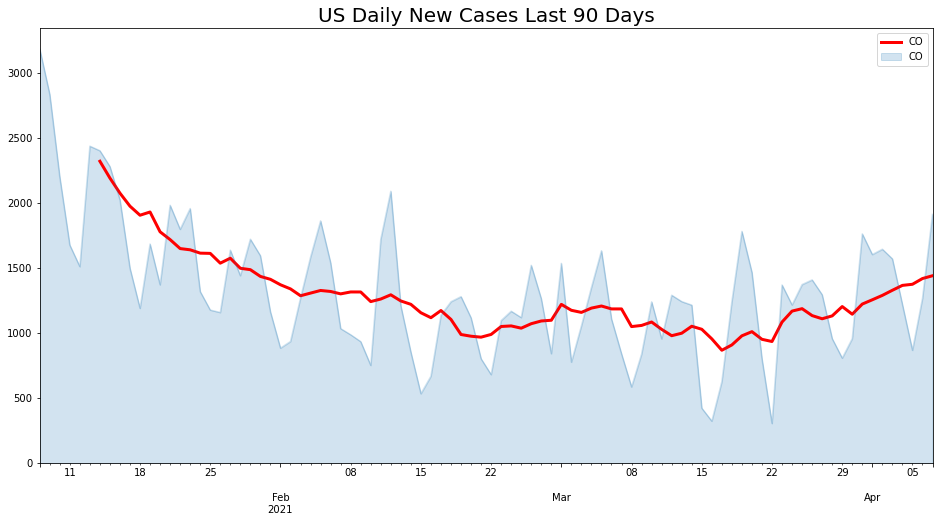

In [22]:
# Plot last 90 days
plt.close('all')
# Select last 90 days only
state_last90 = state.tail(90)

roll_data = state_last90.loc[:,[select_state]].rolling(window=7).mean()
fig,ax = plt.subplots(1,1,figsize=(16,8))
roll_data.plot(ax=ax, linewidth=3, color='r')
state_last90.plot(kind='area',alpha=.2,ax=ax,stacked=False);

plt.title('US Daily New Cases Last 90 Days',fontsize=20)
plt.savefig(f'./covid_data_update/us_{snames}_last_90_days_{day}.png');

In [23]:
# Daily New Cases in tabular format
pd.set_option('display.max_rows', 300)
pd.set_option('display.min_rows', 300)
state.sort_index(ascending = False)

,CO
2021-04-07,1913
2021-04-06,1266
2021-04-05,867
2021-04-04,1220
2021-04-03,1571
2021-04-02,1645
2021-04-01,1604
2021-03-31,1763
2021-03-30,957
2021-03-29,807


### Custom country dictionaries

In [25]:
# creates a custom country dict
c_string = input('Enter country codes seperated by a space:') or 'fr it es uk de'
clist = scd.custom_list (c_string)

country_dict = {key: value for key, value in scd.all_countries.items() if value in clist}
print(country_dict)

print()

Enter country codes seperated by a space: fr


{'france': 'FR'}



### Scraping section

In [26]:
c_list = list(country_dict.values())
c_list

# create an empty pandas df with column headers from country_dict, using the starting dates for the country as index
country = pd.DataFrame(columns = c_list,index=c_index)
country.tail()

base_url='https://www.worldometers.info/coronavirus/country/'
# Here the keys are the country names and the values are the 2-letter abbreviation
for key, value in country_dict.items():
    url = base_url+key
    print(url)

    # scrape web page for country info and assign to soup
    response = requests.get(url)
    #response.status_code
    page = response.text
    #print(response.text[:400])
    soup = bs(page)
    
    # Find block of text/data near 'graph-cases-daily' 
    re_graph = re.compile('graph-cases')
    dat = soup.find(text=re_graph)
   
    try:
        data = soup.find(text=re_graph).parent
    except:
        print(f'Unable to find {url}')
        print()
        break

    # Regex to pull out data chunk out of the larger soup like data
    myregex = re.compile (r'data:.*\]')
    mo = myregex.search(str(data))

    #mo.group() is a string so easy to get rid of the first entry
    country_previous_cases = mo.group().split(',')[1:]
    #print(country_previous_cases)
    previous_cases = ["0" if i == 'null' else i for i in country_previous_cases]
    
    len(previous_cases)

    # merge countries into the existing df and apply the function clean_up to convert strings to ints
    country[value] = previous_cases
    country[value] = country[value].apply(clean_up)
    
    time.sleep(2)
country.clip(lower=0,inplace=True) #large negative number removed for better graphic clarity
country.tail()

['FR']

,FR
2021-04-03,NaN
2021-04-04,NaN
2021-04-05,NaN
2021-04-06,NaN
2021-04-07,NaN


https://www.worldometers.info/coronavirus/country/france


417

,FR
2021-04-03,19789
2021-04-04,60922
2021-04-05,10793
2021-04-06,8045
2021-04-07,0


Countries available: ['FR']



Choose country for rolling averge: 


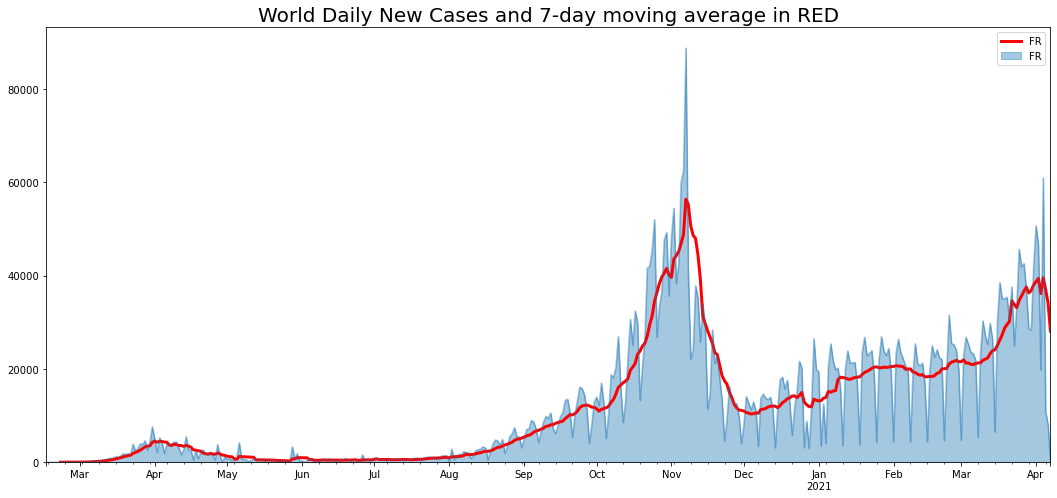

In [27]:
# Allows user to select the country for the rolling average
c_available = list(country.columns)
print(f'Countries available: {c_available}')
print()

snames = (list2string(c_available))

select_country = input('Choose country for rolling averge:') or c_available[0]
select_country = select_country.upper()

if select_country not in c_available:
    select_country = c_available[0]

# Plot Daily New Cases and 7-day moving averge
fig,ax = plt.subplots(1,1,figsize=(18,8))
roll_data = country.loc[:,[select_country]].rolling(window=7).mean()


roll_data.plot(ax=ax, linewidth=3, color='r')
country.plot(kind='area',alpha=.4,ax=ax,stacked=False)
plt.title('World Daily New Cases and 7-day moving average in RED',fontsize=20);
# insert {snames} if desired 
plt.savefig(f'./covid_data_update/world_{day}.png');

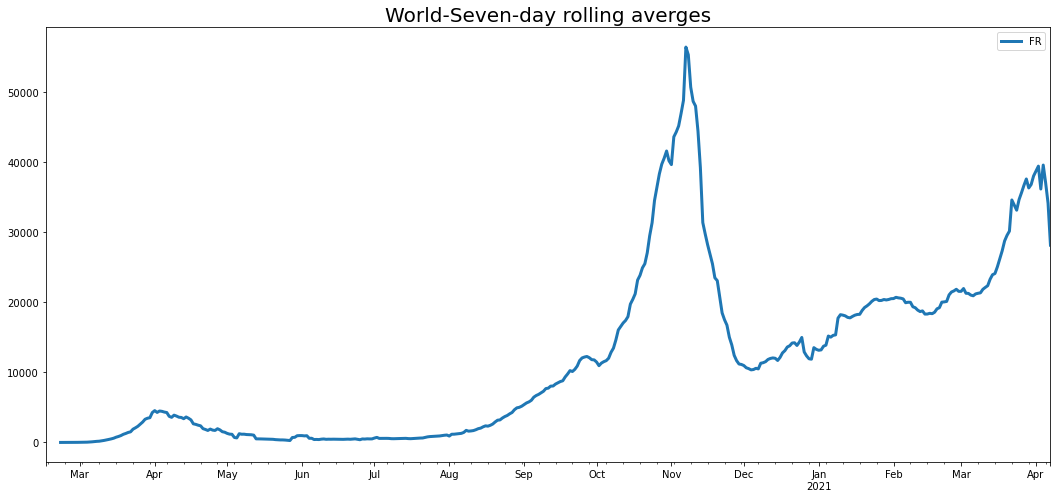

In [28]:
# Plot 7-day moving averge
plt.close('all')
fig,ax = plt.subplots(1,1,figsize=(18,8))
roll_data_all = country.rolling(window=7).mean()
roll_data_all.plot(ax=ax, linewidth=3);
plt.title('World-Seven-day rolling averges',fontsize=20)
# insert {snames} if desired 
plt.savefig(f'./covid_data_update/world_rolling_avg_{day}.png');

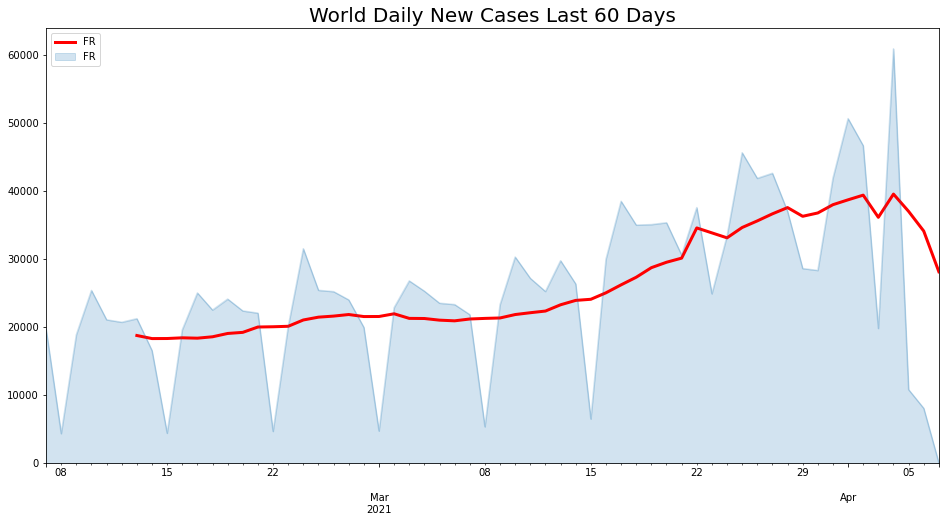

In [29]:
# Plot last 60 days
plt.close('all')
# Select last 60 days only
country_last60 = country.tail(60)

roll_data = country_last60.loc[:,[select_country]].rolling(window=7).mean()
fig,ax = plt.subplots(1,1,figsize=(16,8))
roll_data.plot(ax=ax, linewidth=3, color='r')
country_last60.plot(kind='area',alpha=.2,ax=ax,stacked=False);

plt.title('World Daily New Cases Last 60 Days',fontsize=20)
plt.savefig(f'./covid_data_update/world_{snames}_last_60_days_{day}.png');


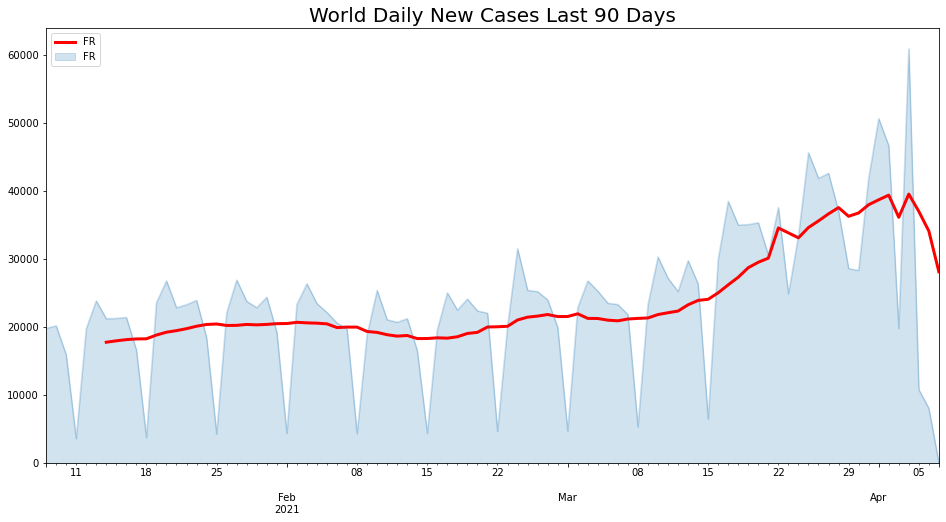

In [30]:
# Plot last 90 days
plt.close('all')
# Select last 90 days only
country_last90 = country.tail(90)

roll_data = country_last90.loc[:,[select_country]].rolling(window=7).mean()
fig,ax = plt.subplots(1,1,figsize=(16,8))
roll_data.plot(ax=ax, linewidth=3, color='r')
country_last90.plot(kind='area',alpha=.2,ax=ax,stacked=False);

plt.title('World Daily New Cases Last 90 Days',fontsize=20)
plt.savefig(f'./covid_data_update/world_{snames}_last_90_days_{day}.png');


In [31]:
# Daily New Cases in tabular format
pd.set_option('display.max_rows', 300)
pd.set_option('display.min_rows', 300)
country.sort_index(ascending = False)

,FR
2021-04-07,0
2021-04-06,8045
2021-04-05,10793
2021-04-04,60922
2021-04-03,19789
2021-04-02,46677
2021-04-01,50659
2021-03-31,41907
2021-03-30,28323
2021-03-29,28604


### Save merged dataframes to csv

In [32]:
# Merge state and country dfs into one
world = state.merge(country,left_index=True,right_index=True,how='outer')
world = world.fillna(0).astype(int)

In [33]:
# Sorting the table with recent dates on the top
world_table = world.sort_index(ascending = False)
# Saving to csv
world_table.to_csv(f'./covid_data/world_table{day}.csv')
world_table.head(5)

,CO,FR
2021-04-07,1913,0
2021-04-06,1266,8045
2021-04-05,867,10793
2021-04-04,1220,60922
2021-04-03,1571,19789


In [34]:
# Note that the last week may be only a partial unless this is executed at end of week
df = world.resample('w').sum()
df.tail(10)

,CO,FR
2021-02-07,9110,139934
2021-02-14,8547,128115
2021-02-21,6778,140018
2021-02-28,7689,150787
2021-03-07,8299,148265
2021-03-14,7366,167429
2021-03-21,6662,210941
2021-03-28,7924,262986
2021-04-04,9567,276881
2021-04-11,4046,18838
